In [ ]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 7.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185311 sha256=fe88b2dda25c71dceb8ff4166b516698a30dbe2cda0044f0c572997adc01a160
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


# Example 1: Calculate sum of an array

In [ ]:
%%file sum.py
from mpi4py import MPI
import numpy as np

COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()
N = 10

if(RANK == 0):
    DATA = np.arange(N*SIZE, dtype='i')
    for i in range(1, SIZE):
        SLICE = DATA[i*N:(i+1)*N]
        COMM.Send([SLICE, MPI.INT], dest=i)
    MYDATA = DATA[0:N]
else:
    MYDATA = np.empty(N, dtype='i')
    COMM.Recv([MYDATA, MPI.INT], source=0)

S = sum(MYDATA)
print(RANK, 'has data', MYDATA, 'sum =', S)

SUMS = np.zeros(SIZE, dtype='i')
if(RANK > 0):
    COMM.send(S, dest=0)
else:
    SUMS[0] = S
    for i in range(1, SIZE):
        SUMS[i] = COMM.recv(source=i)
    print('total sum =', sum(SUMS))

Writing sum.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python sum.py

1 has data [10 11 12 13 14 15 16 17 18 19] sum = 145
3 has data [30 31 32 33 34 35 36 37 38 39] sum = 345
0 has data [0 1 2 3 4 5 6 7 8 9] sum = 45
2 has data [20 21 22 23 24 25 26 27 28 29] sum = 245
total sum = 780


# Example 2: Compute Pi

It is known that the value of π can be computed by the numerical integration:

\begin{equation}
\begin{split}
F(x) & = &  \frac{4.0}{1 + x^2} \\
\pi & = & \int_{0}^{1} F(x) \,dx \\
    & = & \sum_{i=0}^N F(x_i)Δx
\end{split}
\end{equation}

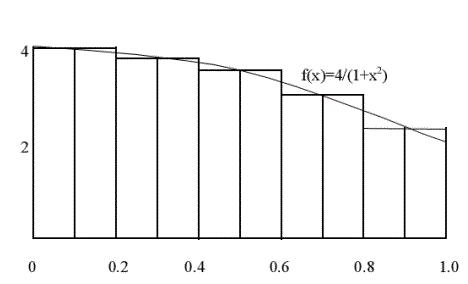

## Sequential Code

In [ ]:
%%file pi_seq.py
import numpy
import math

def compute_pi(n):
  h = 1.0 / n
  s = 0.0
  for i in range(n):
    x = h * (i + 0.5)
    s += 4.0 / (1.0 + x**2)
  return s * h

n = 10
pi = compute_pi(n)
error = abs(pi - math.pi)
print("pi is approximately %.16f, error is %.16f" % (pi, error))

Writing pi_seq.py


In [ ]:
%%time 
!python pi_seq.py

pi is approximately 3.1424259850010987, error is 0.0008333314113056
CPU times: user 9.61 ms, sys: 9.57 ms, total: 19.2 ms
Wall time: 317 ms


## Parallel Version

In [ ]:
%%file pi.py
from mpi4py import MPI
import numpy
import math

def compute_pi(n, start=0, step=1):
  h = 1.0 / n
  s = 0.0
  for i in range(start, n, step):
    print(i)
    x = h * (i + 0.5)
    s += 4.0 / (1.0 + x**2)
  return s * h

# comm = MPI.Comm.Get_parent()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
  n = 4
else:
  n = None

n = comm.bcast(n, root=0)

mypi = compute_pi(n, start=rank, step=size)
pi = comm.reduce(mypi, op=MPI.SUM, root=0)

if rank == 0:
    error = abs(pi - math.pi)
    print("pi is approximately %.16f, error is %.16f" % (pi, error))

Writing pi.py


In [ ]:
%%time 
!mpirun --allow-run-as-root -n 10 python pi.py

0
1
3
2
pi is approximately 3.1468005183939427, error is 0.0052078648041496
CPU times: user 31.2 ms, sys: 9.63 ms, total: 40.9 ms
Wall time: 2.43 s


# Example 3: Mandelbrot Set

## Sequential code

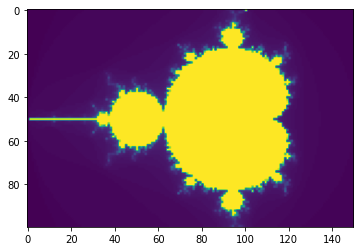

In [ ]:
import numpy as np
from matplotlib import pyplot

def mandelbrot(x, y, maxit):
  c = x + y*1j
  z = 0 + 0j
  it = 0
  while abs(z) < 2 and it < maxit:
    z = z**2 + c
    it += 1
  return it

x1, x2 = -2.0, 1.0
y1, y2 = -1.0, 1.0
w,  h  = 150, 100
maxit  = 127
C = np.zeros([h, w])
dx = (x2 - x1) / w
dy = (y2 - y1) / h
for i in range(h):
  y = y1 + i * dy
  for j in range(w):
    x = x1 + j * dx
    C[i, j] = mandelbrot(x, y, maxit)

from matplotlib import pyplot
pyplot.imshow(C, aspect='equal')
pyplot.show()

## Block distribution

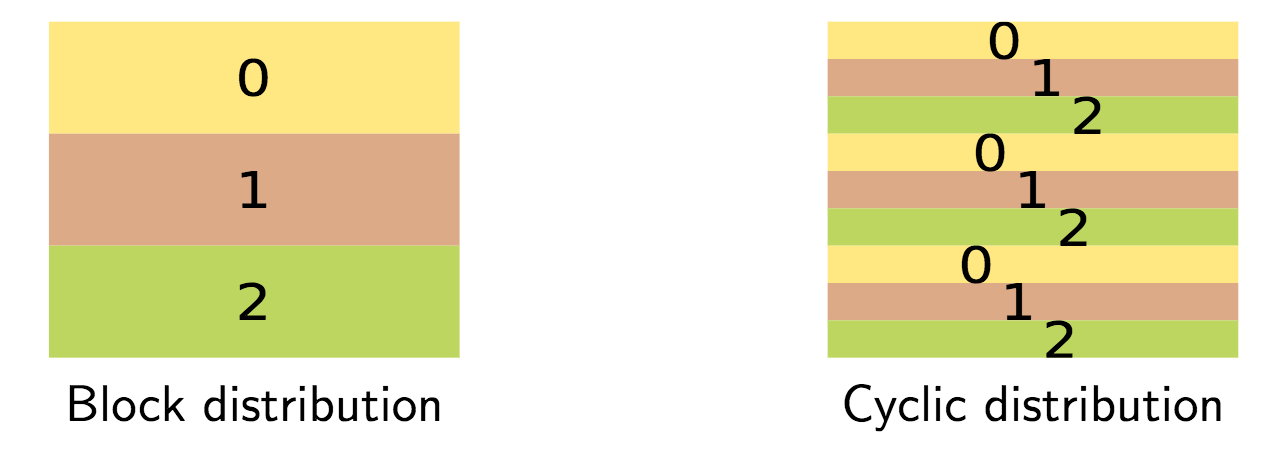

In [ ]:
%%file Mandelbrot_parallel.py
from mpi4py import MPI
import numpy as np
import math
from matplotlib import pyplot

def mandelbrot(x, y, maxit):
  c = x + y*1j
  z = 0 + 0j
  it = 0
  while abs(z) < 2 and it < maxit:
    z = z**2 + c
    it += 1
  return it

x1, x2 = -2.0, 1.0
y1, y2 = -1.0, 1.0
w,  h  = 150, 100
maxit  = 127

# comm = MPI.Comm.Get_parent()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# number of rows to compute here
N = h // size + (h % size > rank)
# first row to compute here
start = comm.scan(N)-N
# array to store local result
Cl = np.zeros([N, w], dtype='i')

# compute owned rows
dx = (x2 - x1) / w
dy = (y2 - y1) / h
for i in range(N):
  y = y1 + (i + start) * dy
  for j in range(w):
    x = x1 + j * dx
    Cl[i, j] = mandelbrot(x, y, maxit)

# gather results at root (process 0)
counts = comm.gather(N, root=0)
C = None
if rank == 0:
  C = np.zeros([h, w], dtype='i')

rowtype = MPI.INT.Create_contiguous(w)
rowtype.Commit()
comm.Gatherv(sendbuf=[Cl, MPI.INT],
             recvbuf=[C, (counts, None),
                      rowtype],
             root=0)
rowtype.Free()

if comm.rank == 0:
  from matplotlib import pyplot
  pyplot.imshow(C, aspect='equal')
  pyplot.savefig('Mandelbrot.png')

Writing Mandelbrot_parallel.py


In [ ]:
!mpirun --allow-run-as-root -n 3 python Mandelbrot_parallel.py

In [ ]:
!ls

hello.py		mpiGather1.py	 mpi_sendrecv2.py	  pi_seq.py
Mandelbrot_parallel.py	mpiGather2.py	 mpiSendRecv2.py	  sample_data
Mandelbrot.png		mpiReduction.py  mpiSendRecv_Exchange.py  sum.py
mpiBroadcast1.py	mpiScatter1.py	 mpi_sendrecv.py
mpiBroadcast2.py	mpiScatter2.py	 mpiSendRecv_Tagged.py
mpiBroadcast3.py	mpiSendRecv1.py  pi.py


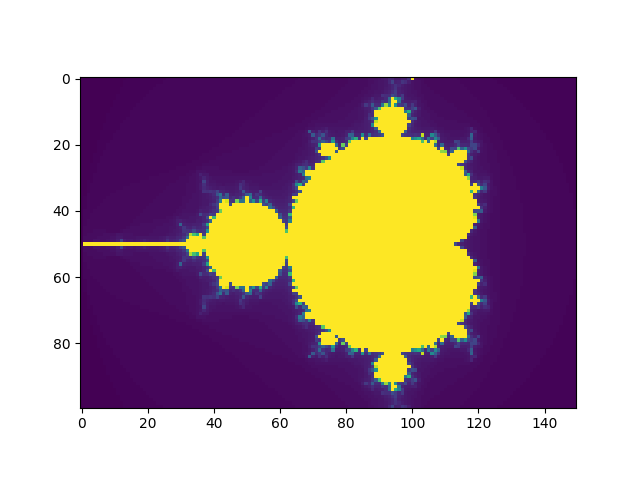

In [ ]:
from IPython.display import Image
Image('Mandelbrot.png')

# Example 4: Matrix-vector Product

Demonstrating a MPI parallel Matrix-Vector Multiplication.

This code will run *iter* iterations of

  v(t+1) = M * v(t)

where v is a vector of length *size* and M a dense size*size
matrix. *size* must be an integer multiple of comm.size.

* v is initialized to be zero except of v[0] = 1.0
* M is a "off-by-one" diagonal matrix M[i, i+1] = 1.0

In effect, after *iter* iterations, the vector v should look like
v[iter] = 1. (all others zero).


In this example every MPI process is responsible for calculating a 
different portion of v. Every process only knows the stripe of M, that 
is relevant for it's calculation. At the end of every iteration, 
Allgather is used to distribute the partial vectors v to all other 
processes.

In [ ]:
%%file matrix-vector-product.py
from __future__ import division
import numpy as np
from numpy.fft import fft2, ifft2
from math import ceil, fabs
from mpi4py import MPI

size = 10000           # lengt of vector v
iter = 20              # number of iterations to run

comm = MPI.COMM_WORLD

print("============================================================================")
print(" Running %d parallel MPI processes" % comm.size)

my_size = size // comm.size     # Every process computes a vector of lenth *my_size*
size = comm.size*my_size        # Make sure size is a integer multiple of comm.size
my_offset = comm.rank*my_size

# This is the complete vector
vec = np.zeros(size)            # Every element zero...
vec[0] = 1.0                    #  ... besides vec[0]

# Create my (local) slice of the matrix
my_M = np.zeros((my_size, size))
for i in range(my_size):
    j = (my_offset+i-1) % size
    my_M[i,j] = 1.0

comm.Barrier()                    ### Start stopwatch ###
t_start = MPI.Wtime()

for t in range(iter):
    my_new_vec = np.inner(my_M, vec)
    
    comm.Allgather(
        [my_new_vec, MPI.DOUBLE], 
        [vec, MPI.DOUBLE] 
    )

comm.Barrier()
t_diff = MPI.Wtime() - t_start    ### Stop stopwatch ###

if fabs(vec[iter]-1.0) > 0.01:
    print("!! Error: Wrong result!")

print(" %d iterations of size %d in %5.2fs: %5.2f iterations per second" %
    (iter, size, t_diff, iter/t_diff) 
)
print("============================================================================")


Overwriting matrix-vector-product.py


In [ ]:
%%time
!mpirun --allow-run-as-root -n 4 python matrix-vector-product.py

 Running 4 parallel MPI processes
 Running 4 parallel MPI processes
 Running 4 parallel MPI processes
 Running 4 parallel MPI processes
 20 iterations of size 10000 in  1.55s: 12.93 iterations per second
 20 iterations of size 10000 in  1.55s: 12.93 iterations per second
 20 iterations of size 10000 in  1.55s: 12.93 iterations per second
 20 iterations of size 10000 in  1.55s: 12.91 iterations per second
CPU times: user 42.4 ms, sys: 11.8 ms, total: 54.2 ms
Wall time: 3.14 s


# Example 5: Matrix-matrix Product

In [ ]:
%%file matrix_product.py

import numpy as np 
from mpi4py import MPI
from time import time

my_N = 3000
my_M = 3000

NORTH = 0
SOUTH = 1
EAST = 2
WEST = 3

def pprint(string, comm=MPI.COMM_WORLD):
    if comm.rank == 0:
        print(string)

if __name__ == "__main__":
    comm = MPI.COMM_WORLD

    mpi_rows = int(np.floor(np.sqrt(comm.size)))
    mpi_cols = comm.size // mpi_rows
    if mpi_rows*mpi_cols > comm.size:
        mpi_cols -= 1
    if mpi_rows*mpi_cols > comm.size:
        mpi_rows -= 1

    pprint("Creating a %d x %d processor grid..." % (mpi_rows, mpi_cols) )

    ccomm = comm.Create_cart( (mpi_rows, mpi_cols), periods=(True, True), reorder=True)

    my_mpi_row, my_mpi_col = ccomm.Get_coords( ccomm.rank ) 
    neigh = [0,0,0,0]
    
    neigh[NORTH], neigh[SOUTH] = ccomm.Shift(0, 1)
    neigh[EAST],  neigh[WEST]  = ccomm.Shift(1, 1)

    # Create matrices
    my_A = np.random.normal(size=(my_N, my_M)).astype(np.float32)
    my_B = np.random.normal(size=(my_N, my_M)).astype(np.float32)
    my_C = np.zeros_like(my_A)

    tile_A = my_A
    tile_B = my_B
    tile_A_ = np.empty_like(my_A)
    tile_B_ = np.empty_like(my_A)
    req = [None, None, None, None]

    t0 = time()
    for r in range(mpi_rows):
        req[EAST]  = ccomm.Isend(tile_A , neigh[EAST])
        req[WEST]  = ccomm.Irecv(tile_A_, neigh[WEST])
        req[SOUTH] = ccomm.Isend(tile_B , neigh[SOUTH])
        req[NORTH] = ccomm.Irecv(tile_B_, neigh[NORTH])

        #t0 = time()
        my_C += np.dot(tile_A, tile_B)
        #t1 = time()

        req[0].Waitall(req)
        #t2 = time()
        #print("Time computing %6.2f  %6.2f" % (t1-t0, t2-t1))
        
    comm.barrier()
    t_total = time()-t0

    t0 = time()
    np.dot(tile_A, tile_B)
    t_serial = time()-t0

    pprint(78*"=")
    pprint("Computed (serial) %d x %d x %d in  %6.2f seconds" % (my_M, my_M, my_N, t_serial))
    pprint(" ... expecting parallel computation to take %6.2f seconds" % (mpi_rows*mpi_rows*mpi_cols*t_serial / comm.size))
    pprint("Computed (parallel) %d x %d x %d in        %6.2f seconds" % (mpi_rows*my_M, mpi_rows*my_M, mpi_cols*my_N, t_total))
    
    #print "[%d] (%d,%d): %s" % (comm.rank, my_mpi_row, my_mpi_col, neigh)

    comm.barrier()

Writing matrix_product.py


In [ ]:
%%time
!mpirun --allow-run-as-root -n 4 python matrix_product.py

Creating a 2 x 2 processor grid...
Computed (serial) 3000 x 3000 x 3000 in    3.95 seconds
 ... expecting parallel computation to take   7.90 seconds
Computed (parallel) 6000 x 6000 x 6000 in          8.24 seconds
CPU times: user 153 ms, sys: 27.4 ms, total: 180 ms
Wall time: 16.6 s


# Static Load balance

In [ ]:
%%file static_loaddist.py
from mpi4py import MPI

COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()

def worker(i):
    """
    The i-th worker turns the received job numbers
    into characters that are sent to the manager.
    Stops when -1 is received.
    """
    while True:
        job = COMM.recv(source=0, tag=11)
        print('worker', i, 'received', job)
        if job == -1: break
        result = chr(ord('a') + job)
        print('worker', i, 'sends', result)
        COMM.send(result, dest=0, tag=12)

def manager(p, n):
    """
    Distributes the n jobs to p-1 workers.
    """
    result = ""
    jobnbr = 1  # current job number
    cntrcv = 0  # number of received results

    while((jobnbr <= n) and (cntrcv < n)):
        for i in range(1, p):
            print('sending job', jobnbr, 'to', i)
            COMM.send(jobnbr, dest=i, tag=11)
            jobnbr = jobnbr + 1
            if jobnbr > n: break
        for i in range(1, p):
            print('receiving from', i)
            c = COMM.recv(source=i, tag=12)
            cntrcv = cntrcv + 1
            result = result + c
            if cntrcv >= n: break

    for i in range(1, p):
        print('sending -1 to', i)
        COMM.send(-1, dest=i, tag=11)
        
    print('the result is', result)
     
def main():
    """
    The manager prompts for the number of jobs per worker.
    """
    if(RANK == 0):
        nbr = 20 # the total number of jobs 
        manager(SIZE, nbr)
    else:
        worker(RANK)

main()

Overwriting static_loaddist.py


In [ ]:
%%time
!mpirun --allow-run-as-root -n 4 python static_loaddist.py

sending job 1 to 1
sending job 2 to 2
sending job 3 to 3
worker 2 received 2
receiving from 1
worker 3 received 3
worker 2 sends c
worker 3 sends d
worker 1 received 1
worker 1 sends b
receiving from 2
receiving from 3
sending job 4 to 1
sending job 5 to 2
worker 1 received 4
sending job 6 to 3
worker 2 received 5
worker 1 sends e
receiving from 1
worker 3 received 6
receiving from 2
worker 2 sends f
worker 3 sends g
receiving from 3
sending job 7 to 1
sending job 8 to 2
worker 1 received 7
sending job 9 to 3
worker 2 received 8
worker 1 sends h
receiving from 1
worker 3 received 9
worker 2 sends i
receiving from 2
worker 3 sends j
receiving from 3
sending job 10 to 1
sending job 11 to 2
worker 1 received 10
sending job 12 to 3
worker 2 received 11
worker 1 sends k
receiving from 1
worker 3 received 12
worker 2 sends l
receiving from 2
worker 3 sends m
receiving from 3
sending job 13 to 1
sending job 14 to 2
worker 1 received 13
sending job 15 to 3
worker 2 received 14
worker 1 sends n

# Dynamic Load Balancing

In [ ]:
%%file dynamic_loaddist.py

from random import randint
from time import sleep
from mpi4py import MPI

COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()

def worker(i):
    """
    The i-th worker turns the received job numbers
    into characters that are sent to the manager.
    To simulate an uneven load, each worker sleeps
    between 1 and 9 seconds, before sending a character.
    Stops when -1 is received.
    """
    while True:
        job = COMM.recv(source=0, tag=11)
        print('worker', i, 'received', job)
        if job == -1: break
        rnd = randint(1, 9)
        print('worker', i, 'sleeps', rnd, 'seconds ...')
        sleep(rnd)
        result = chr(ord('a') + job)
        print('worker', i, 'sends', result)
        COMM.send(result, dest=0, tag=12)

def manager(p, n):
    """
    Distributes the n jobs to p-1 workers.
    Probes for incoming messages.
    """
    result = ""
    jobnbr = 1  # current job number
    cntrcv = 0  # number of received results
    
    for i in range(1, p):
        print('sending job', jobnbr, 'to', i)
        COMM.send(jobnbr, dest=i, tag=11)
        jobnbr = jobnbr + 1
        if jobnbr > n: break

    while cntrcv < n:
        state = MPI.Status()
        okay = COMM.Iprobe(source=MPI.ANY_SOURCE, \
            tag=MPI.ANY_TAG, status=state)
        if not okay:
            sleep(0.5)
        else:
            node = state.Get_source()
            c = COMM.recv(source=node, tag=12)
            print('received', c, 'from', node)
            cntrcv = cntrcv + 1
            result = result + c
            if jobnbr > n:
                print('sending -1 to', node)
                COMM.send(-1, dest=node, tag=11)
            else:
                print('sending job', jobnbr, 'to', node)
                COMM.send(jobnbr, dest=node, tag=11)
                jobnbr = jobnbr + 1
    print('the result is', result)
     
def main():
    """
    The manager prompts for the number of jobs per worker.
    """
    if(RANK == 0):
        nbr = 20 # Total number of jobs 
        manager(SIZE, nbr)
    else:
        worker(RANK)

main()

Overwriting dynamic_loaddist.py


In [ ]:
%%time
!mpirun --allow-run-as-root -n 4 python dynamic_loaddist.py

sending job 1 to 1
sending job 2 to 2
sending job 3 to 3
worker 3 received 3
worker 2 received 2
worker 3 sleeps 4 seconds ...
worker 2 sleeps 7 seconds ...
worker 1 received 1
worker 1 sleeps 1 seconds ...
worker 1 sends b
received b from 1
sending job 4 to 1
worker 1 received 4
worker 1 sleeps 5 seconds ...
worker 3 sends d
received d from 3
sending job 5 to 3
worker 3 received 5
worker 3 sleeps 3 seconds ...
worker 1 sends e
worker 2 sends c
received e from 1
sending job 6 to 1
received c from 2
sending job 7 to 2
worker 1 received 6
worker 2 received 7
worker 1 sleeps 2 seconds ...
worker 2 sleeps 1 seconds ...
worker 3 sends f
received f from 3
sending job 8 to 3
worker 3 received 8
worker 2 sends h
worker 3 sleeps 8 seconds ...
received h from 2
sending job 9 to 2
worker 1 sends g
worker 2 received 9
worker 2 sleeps 1 seconds ...
received g from 1
sending job 10 to 1
worker 1 received 10
worker 1 sleeps 7 seconds ...
worker 2 sends j
received j from 2
sending job 11 to 2
worker 2